In [1]:
import os
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [2]:
def crop(img, x, y, width, height):
    return img[y:y+height, x:x+width]

import cv2 

face_cascade = cv2.CascadeClassifier("haarcascade_face.xml") 
RESIZE_SIZES = {
    "single":(50, 50),
    "double":(100, 50)
}
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")  # capture frames from a camera 
FACE_PERC = 0.6 # percentage of face where you need eyes.
cap = cv2.VideoCapture("merged_new.mp4") 
N_FPS = 1
RESIZE = True
SHOW = True
fps = cap.get(cv2.CAP_PROP_FPS)
val = int(fps/N_FPS)
eyes_list = []
both_eyes = []
mode = "gray"
assert mode in  ["gray", "rbg"], f"mode must be either gray or rgb not {mode}"
# loop runs if capturing has been initialized. 
while 1:  
    # reads frames from a camera 
    ret, img = cap.read()  
    fno = int(cap.get(1))
    if not ret:
        break   
    # print("here")
    if fno % val != 0:
        continue
    # convert to gray scale of each frames 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # print(fno)
    # Detects faces of different sizes in the input image 
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) 
    if len(faces) < 1:
        continue
    for (x,y,w,h) in faces[:1]: 
        # To draw a rectangle in a facee  
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)  
        roi_gray = gray[y:y+h, x:x+w] 
        roi_color = img[y:y+h, x:x+w] 
  
        # Detects eyes of different sizes in the input image 
        eyes = eye_cascade.detectMultiScale(roi_gray)  
        #To draw a rectangle in eyes 
        count = 0
        ex_list = []
        ey_list = []
        x_end = []
        y_end = []
        if len(eyes) < 2:
            eyes_list.append([None, None])
            both_eyes.append(None)
            continue
        temp_list = []
        for (ex,ey,ew,eh) in eyes:
            if ey + eh <= roi_gray.shape[1] * FACE_PERC:
                count += 1
                ex_list.append(ex)
                ey_list.append(ey)
                x_end.append(ex + ew)
                y_end.append(ey + eh)
                if mode == "gray":
                    temp_list.append(crop(roi_gray, ex, ey, ew, eh))
                    # cv2.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,127,255),2)
                else:
                    temp_list.append(crop(roi_color, ex, ey, ew, eh))
                    # cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,127,255),2)
        
    # print(ex_list)
    # print(ey_list)
    # Display an image in a window
    if count >= 2:
        if ex_list[0] < ex_list[1]:
            pass
        else:
            # print('swapped')
            temp_list[1], temp_list[0] = temp_list[0], temp_list[1]
        if RESIZE:
            temp_list[0] = cv2.resize(temp_list[0], RESIZE_SIZES["single"])
            temp_list[1] = cv2.resize(temp_list[1], RESIZE_SIZES["single"])
        eyes_list.append(temp_list)
        # print(2)
        cv2.imshow("eye1",cv2.hconcat([temp_list[0], temp_list[1]]))
        # cv2.imshow("eye2",temp_list[1])
        min_ex = min(ex_list)
        min_ey = min(ey_list)        
        max_ex = max(x_end)
        max_ey = max(y_end)
        # req_w = max_ex - min_ex
        # req_h = max_ey - min_ey
        # cv2.rectangle(roi_gray,(min_ex,min_ey),(max_ex, max_ey),(0,127,255),2)
        if mode == "gray":
            both = crop(roi_gray, min_ex, min_ey, max_ex - min_ex, max_ey - min_ey)   
        else:
            both = crop(roi_color, min_ex, min_ey, max_ex - min_ex, max_ey - min_ey)   
        if RESIZE:
            both = cv2.resize(both, RESIZE_SIZES["double"])
        both_eyes.append(both)
        cv2.imshow("both_eyes", both)
        if SHOW:
            cv2.imshow('img',img)
            cv2.imshow("new", roi_gray)
    else:
        eyes_list.append([None, None])
        both_eyes.append(None)
        continue
    # Wait for Esc key to stop 
    k = cv2.waitKey(5)
    if k == 27: 
        break
    # cv2.waitKey(0)
    # break
  
# Close the window 
cap.release() 
  
# De-allocate any associated memory usage 
cv2.destroyAllWindows()  

In [3]:
import cv2 

FACE_CASCADE = cv2.CascadeClassifier("haarcascade_face.xml") 
RESIZE_SIZES = {
    "single":(50, 50),
    "double":(100, 50)
}
RESIZE = True
FACE_PERC = 0.6
N_FPS = 1
SHOW = True
EYE_CASCADE = cv2.CascadeClassifier("haarcascade_eye.xml")  # capture frames from a camera 
MODE = "rgb"
def predict_eyes(video_path:str, face_perc:float, n_fps:int, resize:bool, show:bool, mode:str, resize_sizes:dict):
    # assert os.path.exists(video_path), f"Given path {video_path} does not exists"
    cap = cv2.VideoCapture(video_path) 
    fps = cap.get(cv2.CAP_PROP_FPS)
    if not cap.isOpened():
        return f"Unable to read given file {video_path}"
    val = int(fps/N_FPS)
    eyes_list = []
    both_eyes = []
    no_face = 0
    no_eyes = 0
    assert mode in  ["gray", "rgb"], f"mode must be either gray or rgb not {mode}"
    # loop runs if capturing has been initialized. 
    while 1:  
        # reads frames from a camera 
        ret, img = cap.read()  
        fno = int(cap.get(1))
        if not ret:
            break   
        # print("here")
        if fno % val != 0:
            continue
        # convert to gray scale of each frames 
        # cv2.imshow('img',img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        # print(fno)
        # Detects faces of different sizes in the input image 
        faces = FACE_CASCADE.detectMultiScale(gray, 1.3, 5) 
        if len(faces) < 1:
            print("no_face")
            no_face += 1
            continue
        
        
        for (x,y,w,h) in faces[:1]: 
            # To draw a rectangle in a facee  
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)  
            roi_gray = gray[y:y+h, x:x+w] 
            roi_color = img[y:y+h, x:x+w] 
            # cv2.imshow('img',img)
            # Detects eyes of different sizes in the input image 
            eyes = EYE_CASCADE.detectMultiScale(roi_gray)  
            #To draw a rectangle in eyes 
            count = 0
            ex_list = []
            ey_list = []
            x_end = []
            y_end = []
            if len(eyes) < 2:
                # eyes_list.append([None, None])
                # both_eyes.append(None)
                print("no eyes")
                no_eyes += 1
                continue
            temp_list = []
            for (ex,ey,ew,eh) in eyes:
                if ey + eh <= roi_gray.shape[1] * face_perc:
                    count += 1
                    ex_list.append(ex)
                    ey_list.append(ey)
                    x_end.append(ex + ew)
                    y_end.append(ey + eh)
                    if mode == "gray":
                        temp_list.append(crop(roi_gray, ex, ey, ew, eh))
                        # cv2.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,127,255),2)
                    else:
                        temp_list.append(crop(roi_color, ex, ey, ew, eh))
                        # cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,127,255),2)
            
        # print(ex_list)
        # print(ey_list)
        # Display an image in a window
        if count >= 2:
            if ex_list[0] < ex_list[1]:
                pass
            else:
                # print('swapped')
                temp_list[1], temp_list[0] = temp_list[0], temp_list[1]
            if RESIZE:
                temp_list[0] = cv2.resize(temp_list[0], resize_sizes["single"])
                temp_list[1] = cv2.resize(temp_list[1], resize_sizes["single"])
            eyes_list.append(temp_list)
            # print(2)
            if show:
                cv2.imshow("eye1",cv2.hconcat([temp_list[0], temp_list[1]]))
            # cv2.imshow("eye2",temp_list[1])
            min_ex = min(ex_list)
            min_ey = min(ey_list)        
            max_ex = max(x_end)
            max_ey = max(y_end)
            # req_w = max_ex - min_ex
            # req_h = max_ey - min_ey
            # cv2.rectangle(roi_gray,(min_ex,min_ey),(max_ex, max_ey),(0,127,255),2)
            if mode == "gray":
                both = crop(roi_gray, min_ex, min_ey, max_ex - min_ex, max_ey - min_ey)   
            else:
                both = crop(roi_color, min_ex, min_ey, max_ex - min_ex, max_ey - min_ey)   
            if resize:
                both = cv2.resize(both, resize_sizes["double"])
            both_eyes.append(both)

            
            if show:
                cv2.imshow("both_eyes", both)
                cv2.imshow('img',img)
                cv2.imshow("new", roi_gray)
        else:
            # eyes_list.append([None, None])
            # both_eyes.append(None)
            continue
        # Wait for Esc key to stop 
        # cv2.imshow('img',img)

        k = cv2.waitKey(5)
        if k == 27: 
            break
        # cv2.waitKey(0)
        # break
    
    # Close the window 
    cap.release() 
    
    # De-allocate any associated memory usage 
    cv2.destroyAllWindows() 
    return eyes_list, both_eyes, no_eyes, no_face 

In [154]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [171]:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]
cap = cv2.VideoCapture(0)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.  
      continue
    # image = cv2.filp(image, 1)
    rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)

    # Draw the face mesh annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
      mesh_points = np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in results.multi_face_landmarks[0].landmark])
      cv2.polylines(image, [mesh_points[LEFT_EYE]], True, (0, 255, 0), 1, cv2.LINE_AA)
      cv2.polylines(image, [mesh_points[RIGHT_EYE]], True, (0, 255, 0), 1, cv2.LINE_AA)
      # for face_landmarks in results.multi_face_landmarks:
      #   mp_drawing.draw_landmarks(
      #       image=image,
      #       landmark_list=face_landmarks,
      #       connections=mp_face_mesh.FACEMESH_TESSELATION,
      #       landmark_drawing_spec=None,
      #       connection_drawing_spec=mp_drawing_styles
      #       .get_default_face_mesh_tesselation_style())
      #   mp_drawing.draw_landmarks(
      #       image=image,
      #       landmark_list=face_landmarks,
      #       connections=mp_face_mesh.FACEMESH_CONTOURS,
      #       landmark_drawing_spec=None,
      #       connection_drawing_spec=mp_drawing_styles
      #       .get_default_face_mesh_contours_style())
      #   mp_drawing.draw_landmarks(
      #       image=image,
      #       landmark_list=face_landmarks,
      #       connections=mp_face_mesh.FACEMESH_IRISES,
      #       landmark_drawing_spec=None,
      #       connection_drawing_spec=mp_drawing_styles
      #       .get_default_face_mesh_iris_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Face Mesh', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()
cv2.destroyAllWindows()

In [164]:
for i in results.multi_face_landmarks:
    print(i["x"])
    break

TypeError: 'NormalizedLandmarkList' object is not subscriptable

In [157]:
results

mediapipe.python.solution_base.SolutionOutputs

In [137]:
eyes, both, no_eyes, no_face = predict_eyes(video_path="merged_new.mp4",
                face_perc=FACE_PERC,
                n_fps= N_FPS,
                resize= RESIZE,
                show= SHOW,mode= MODE, 
                resize_sizes= RESIZE_SIZES)

no_face
no eyes
no eyes
no eyes
no eyes


In [138]:
both_eyes = np.array(list(map(lambda x:x.flatten(), both)))
both_eyes.shape

eyes_stacked = list(map(lambda x: np.vstack([x[0], x[1]]).flatten(), eyes))


In [139]:
iso_model = IsolationForest(n_estimators=200)
predicts = iso_model.fit_predict(both_eyes)
predicts

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [140]:
# # roi = np.hstack([eyes[0][0], eyes[0][1]])
# # idx_val = -2
# roi = both[idx_val]
# roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
# if MODE == "gray":
#     plt.imshow(roi, cmap="gray")
#     plt.title(predicts[idx_val])
# else:
#     plt.imshow(roi)
#     plt.title(predicts[idx_val])


# plt.show()
# # gray_roi = cv2.GaussianBlur(roi, (7, 7), 0)
# gray_roi = roi.copy()
# gray_roi = cv2.cvtColor(gray_roi, cv2.COLOR_RGB2GRAY)
# rows, cols= gray_roi.shape

# _, threshold = cv2.threshold(gray_roi, 35, 255, cv2.THRESH_BINARY_INV)
# contours,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

# for cnt in contours[-2:]:
#     print("yes")
#     (x, y, w, h) = cv2.boundingRect(cnt)

#     #cv2.drawContours(roi, [cnt], -1, (0, 0, 255), 3)
#     cv2.rectangle(gray_roi, (x, y), (x + w, y + h), (255, 0, 0), 2)
#     # cv2.line(gray_roi, (x + int(w/2), 0), (x + int(w/2), rows), (0, 255, 0), 2)
#     # cv2.line(gray_roi, (0, y + int(h/2)), (cols, y + int(h/2)), (0, 255, 0), 2)
    


# plt.imshow(gray_roi, cmap="gray")
# plt.show()

In [141]:
# gray_roi = cv2.GaussianBlur(np.hstack([eyes[0][0], eyes[0][1]]), (7, 7), 0)
# rows, cols= gray_roi.shape

# _, threshold = cv2.threshold(gray_roi, 35, 255, cv2.THRESH_BINARY_INV)
# contours,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

# for cnt in contours:
#     print("yes")
#     (x, y, w, h) = cv2.boundingRect(cnt)

#     #cv2.drawContours(roi, [cnt], -1, (0, 0, 255), 3)
#     cv2.rectangle(gray_roi, (x, y), (x + w, y + h), (255, 0, 0), 2)
#     # cv2.line(gray_roi, (x + int(w/2), 0), (x + int(w/2), rows), (0, 255, 0), 2)
#     # cv2.line(gray_roi, (0, y + int(h/2)), (cols, y + int(h/2)), (0, 255, 0), 2)
#     # break

In [142]:
# cv2.imshow("Countour",gray_roi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [143]:
# np.hstack([eyes[0][0], eyes[0][1]])

In [144]:
iso_model_stack = IsolationForest(n_estimators=200)
predicts_stack = iso_model_stack.fit_predict(eyes_stacked)
predicts_stack

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [145]:
eyes_arr = np.array(list(map(lambda x:np.array([x[0], x[1]]), eyes)))
both_arr = np.array(both)

In [146]:
confident = np.sum(predicts == 1)
not_confident = np.sum(predicts == -1)
print(f"Ratio : {confident/(confident+not_confident + no_eyes, no_face)}")


Ratio : [  0.91967871 229.        ]


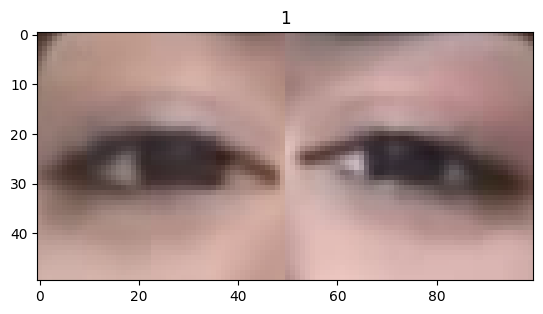

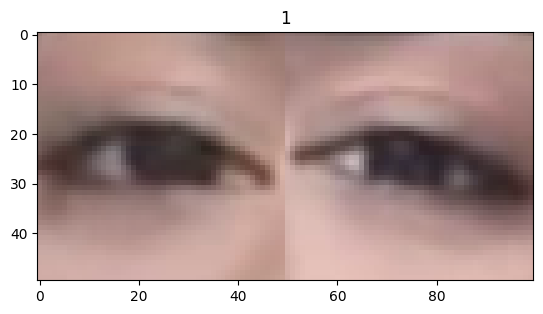

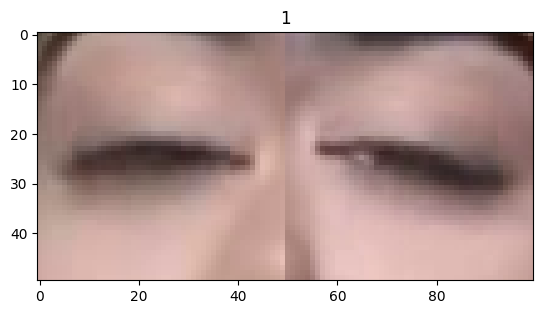

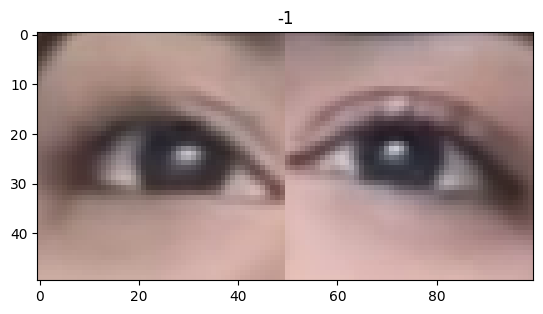

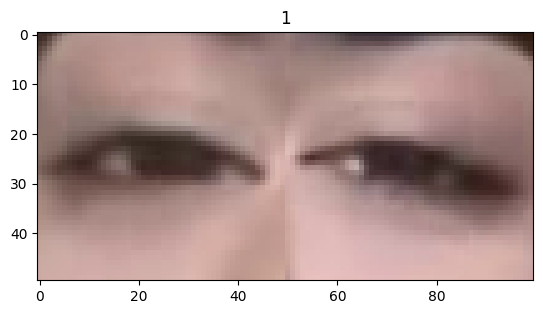

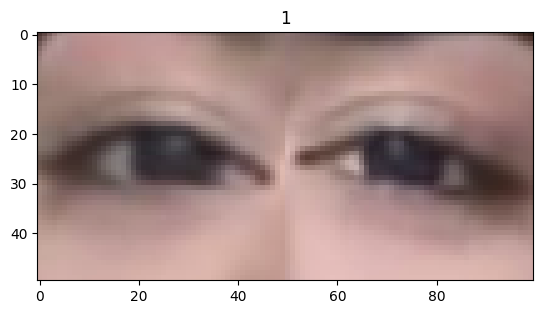

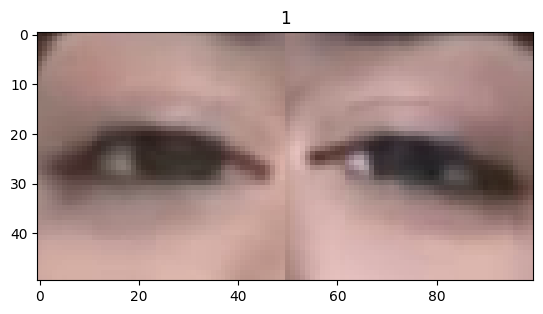

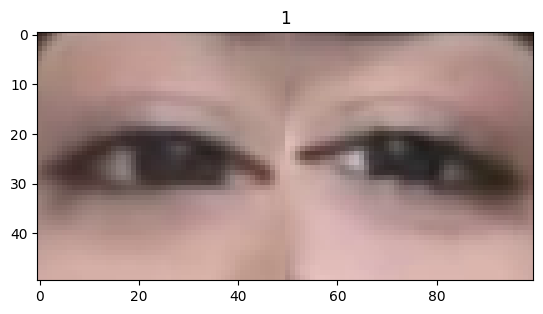

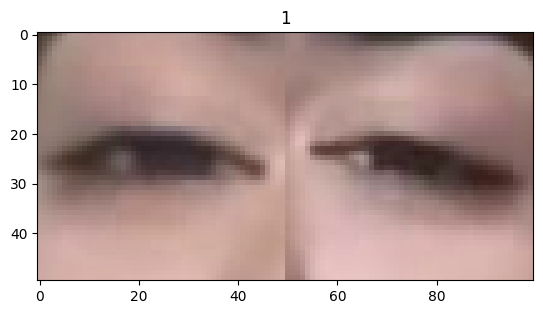

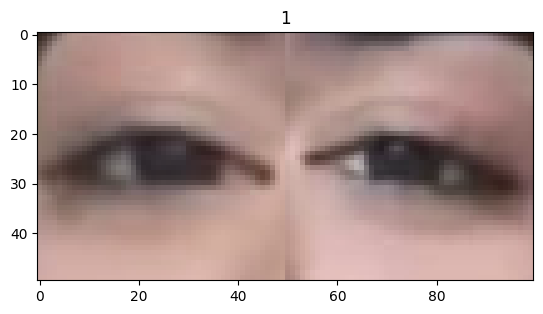

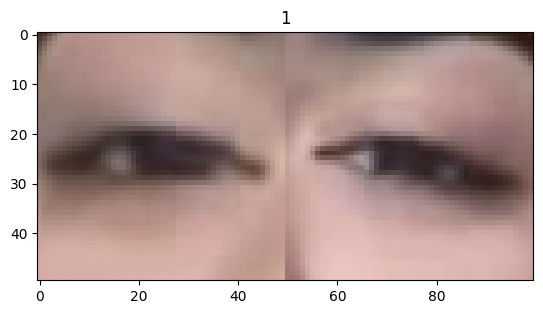

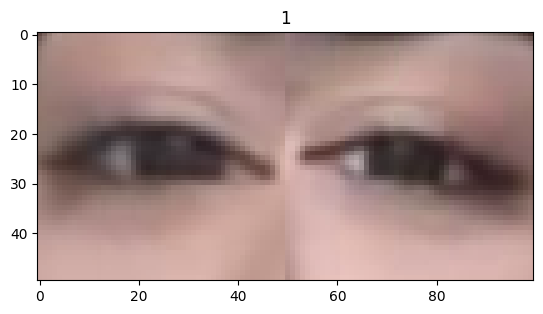

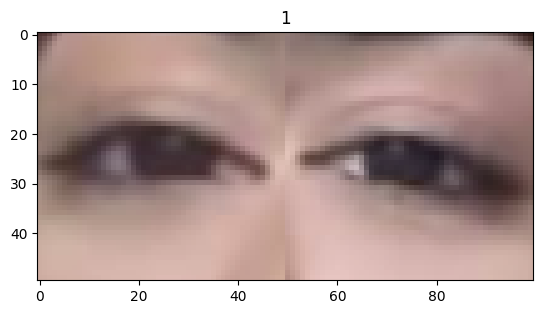

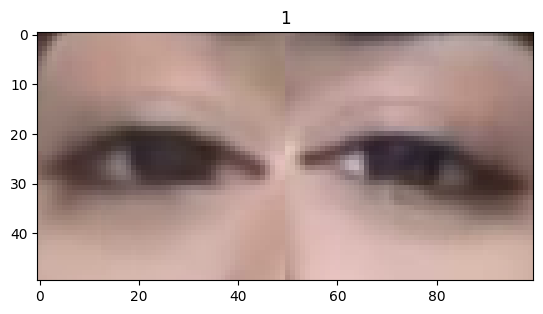

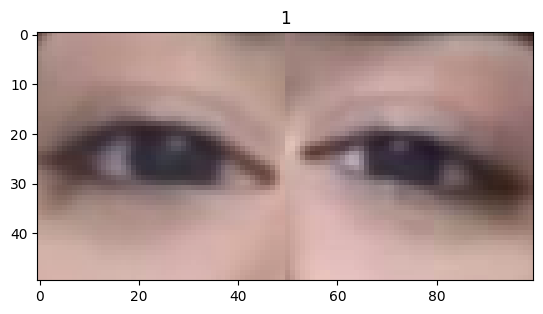

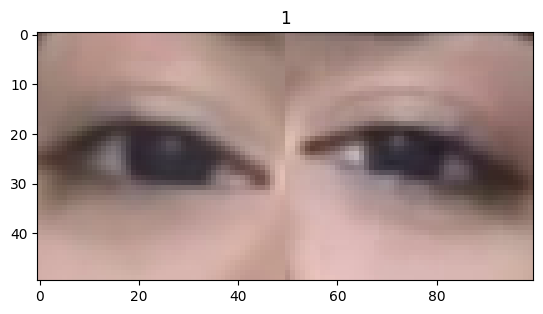

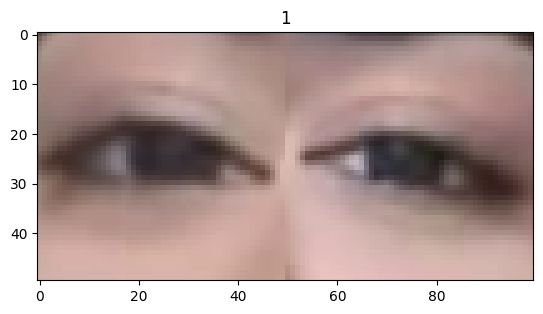

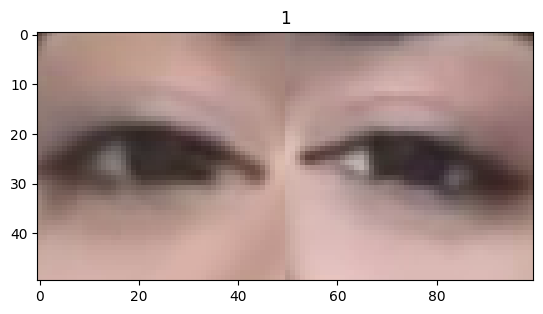

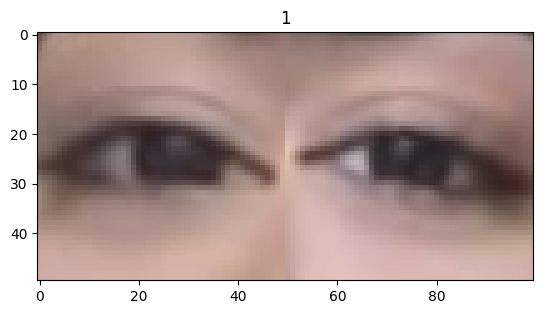

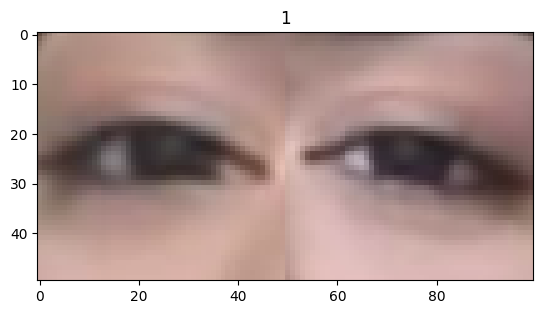

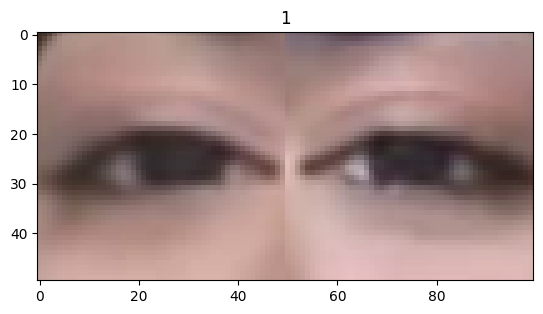

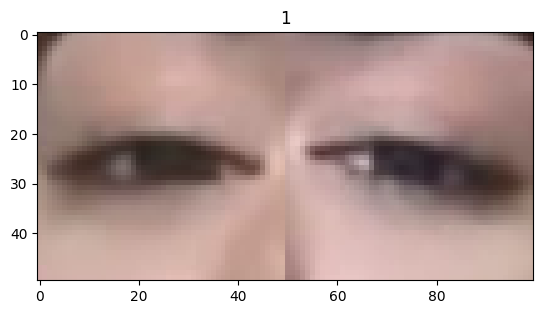

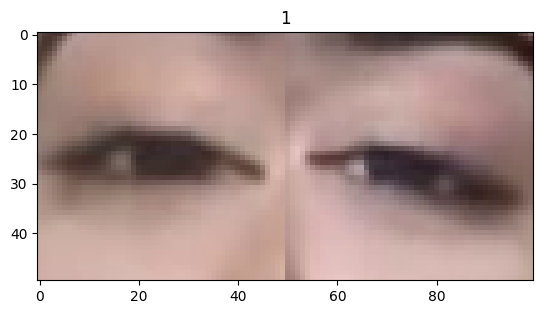

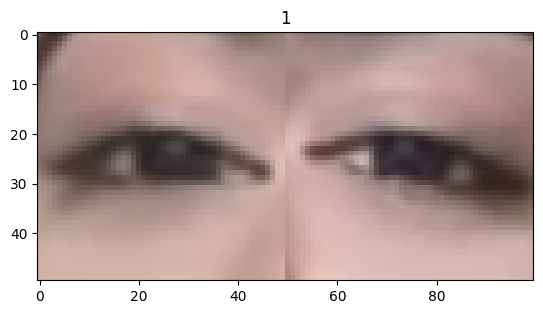

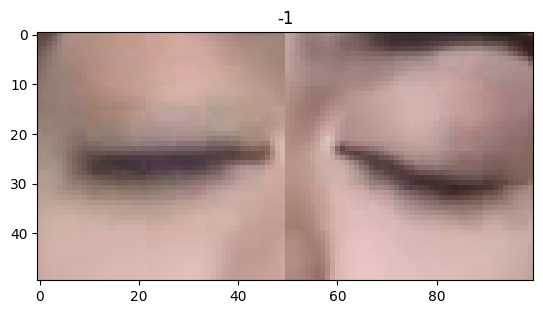

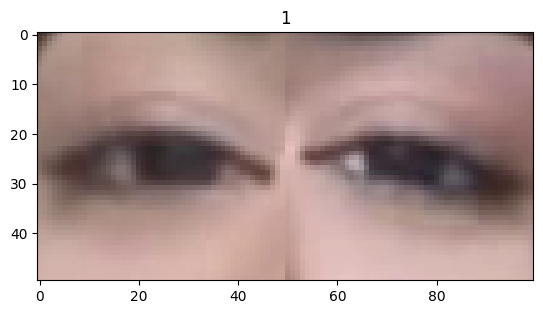

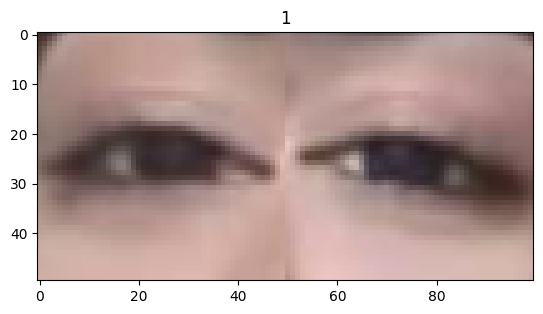

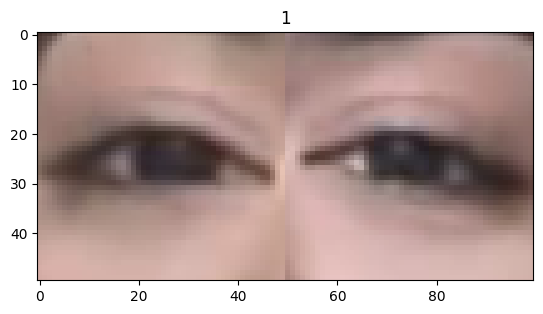

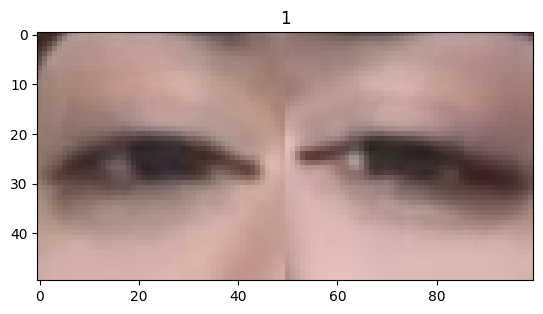

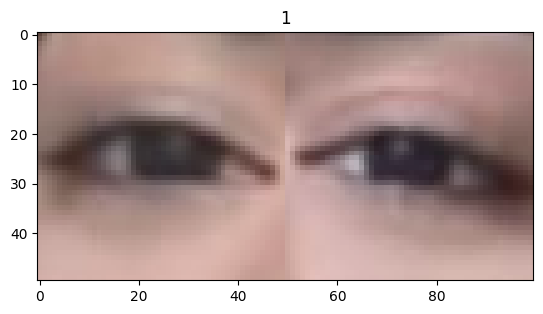

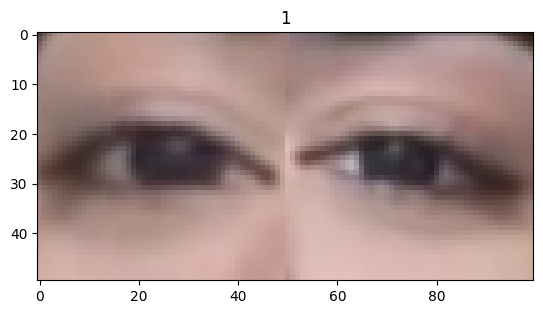

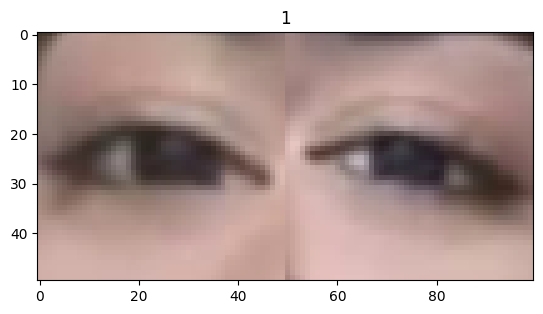

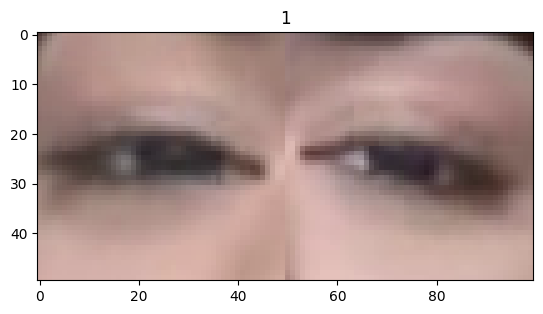

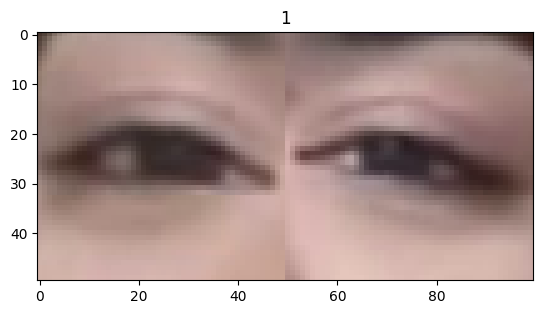

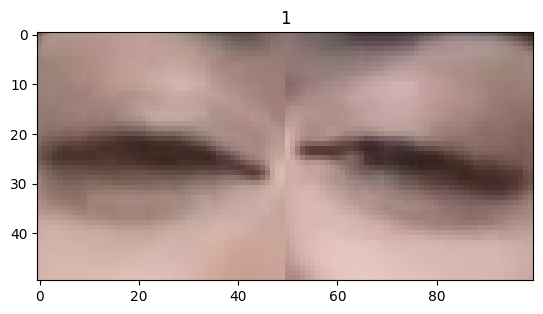

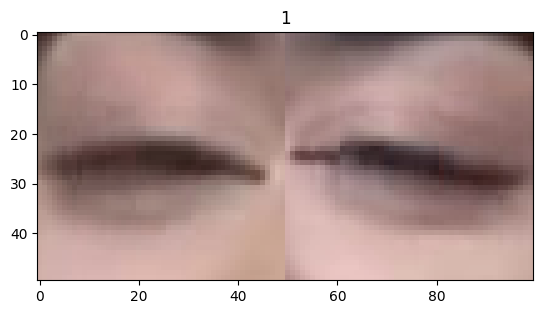

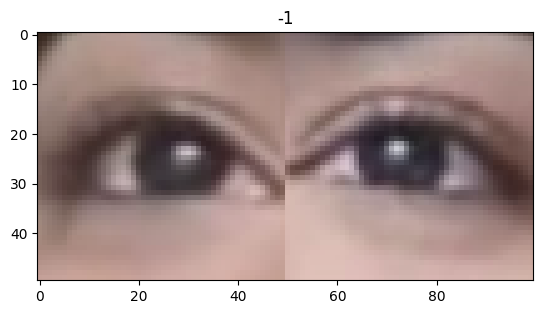

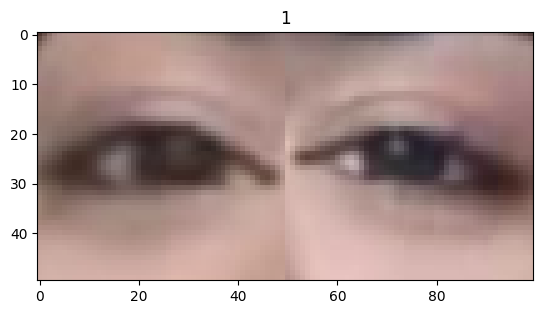

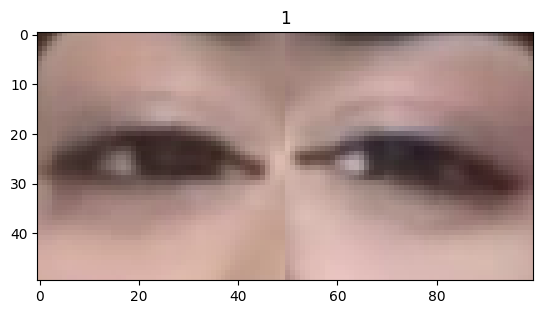

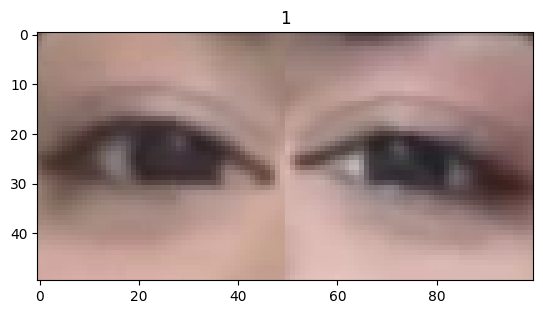

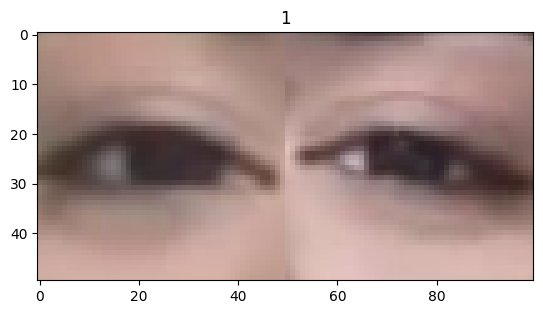

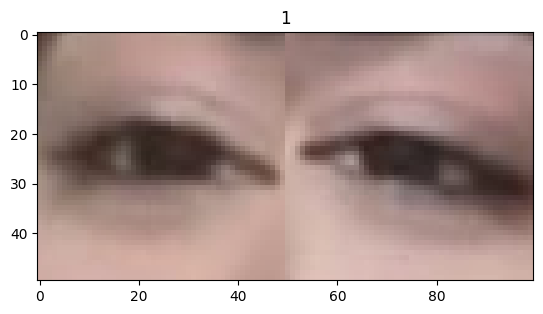

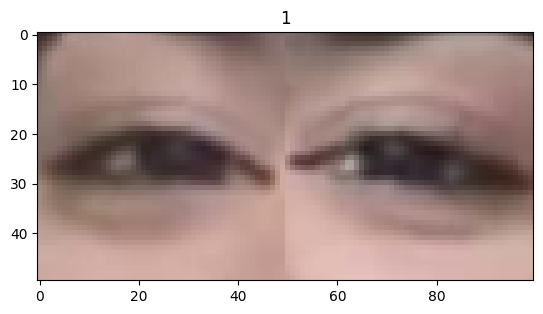

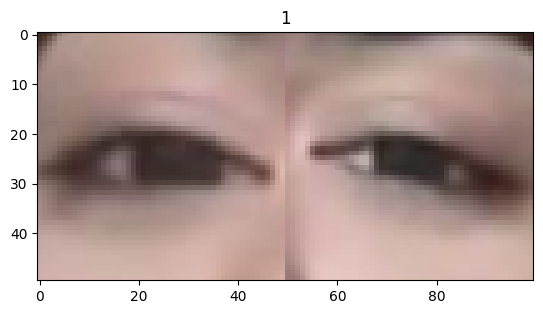

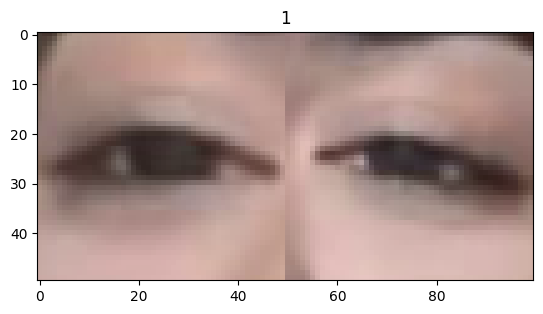

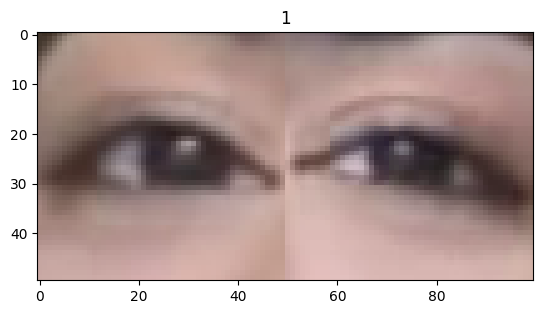

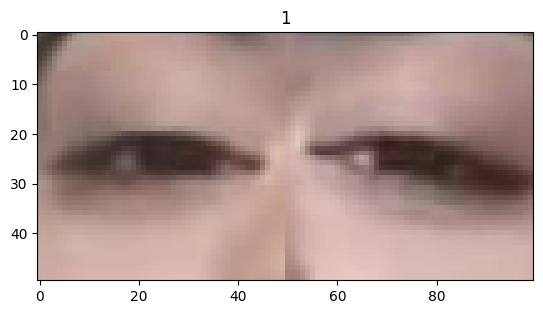

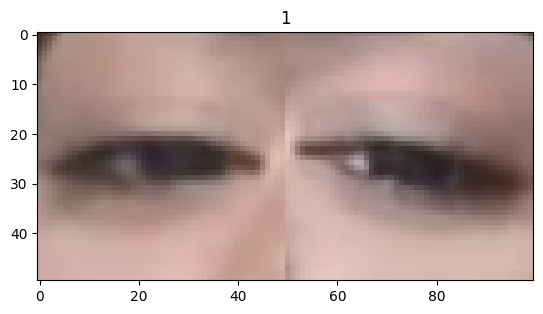

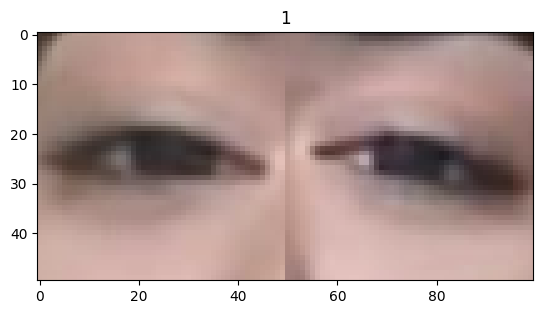

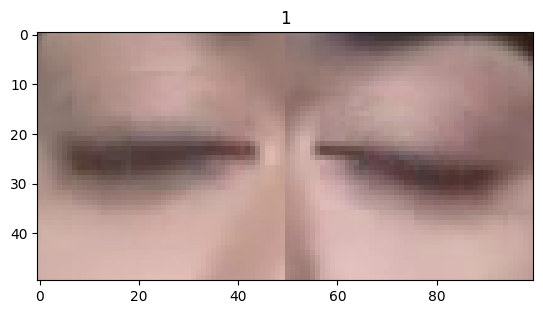

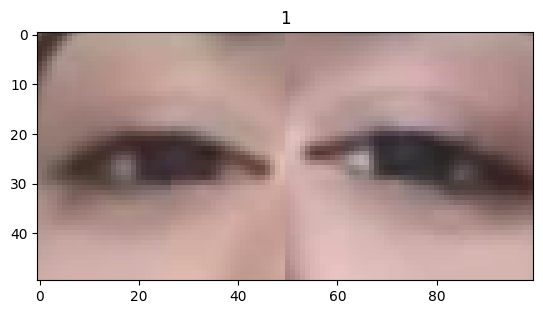

In [152]:
# fig = plt.subplots(NROWS, NCOLS)
for idx, i in enumerate(predicts_stack):
    if idx < 100:
        continue
    if idx > 150:
        break
    if MODE == "gray":
        plt.imshow(np.hstack([eyes[idx][0], eyes[idx][1]]), cmap="gray")
    else:
        
        plt.imshow(cv2.cvtColor(np.hstack([eyes[idx][0], eyes[idx][1]]), cv2.COLOR_BGR2RGB))

    plt.title(i)
    plt.show()




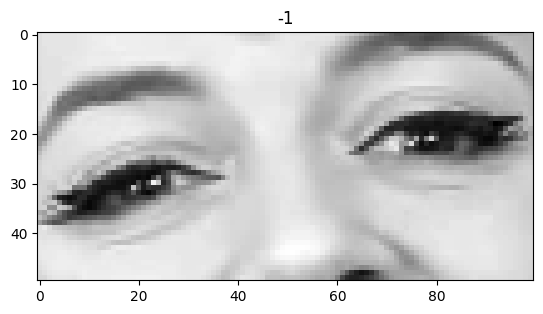

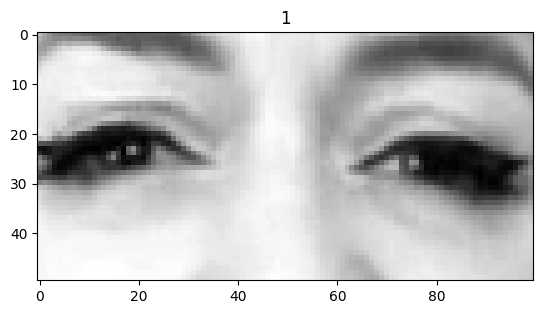

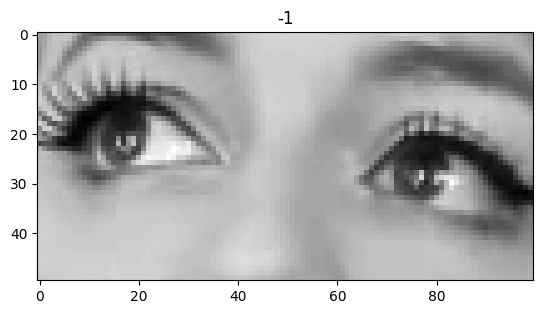

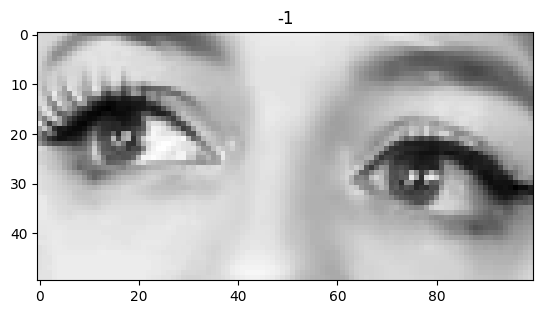

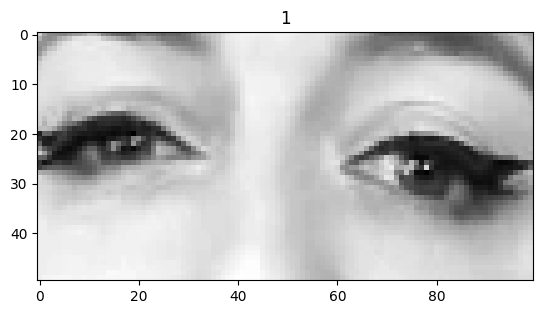

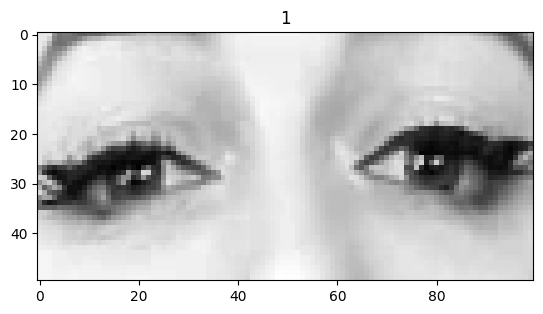

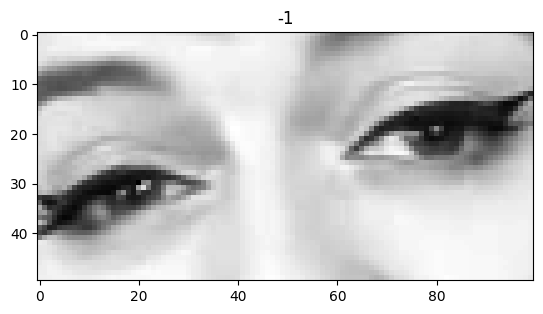

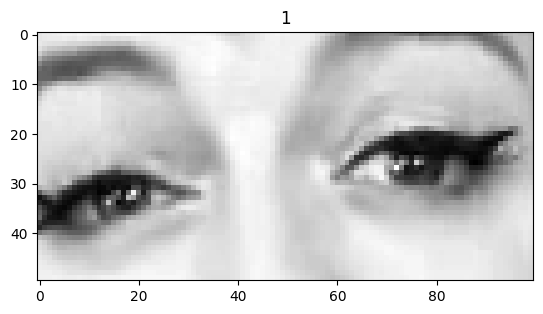

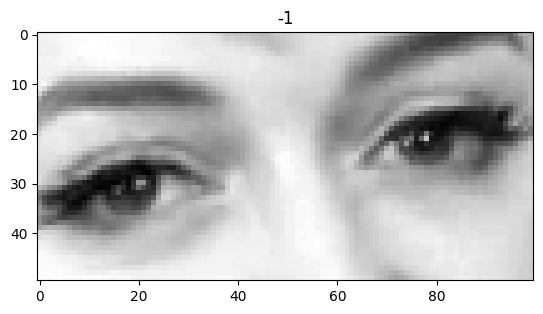

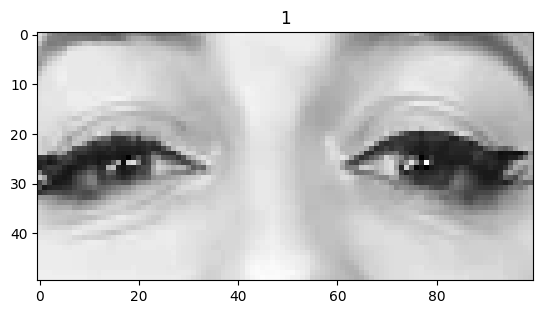

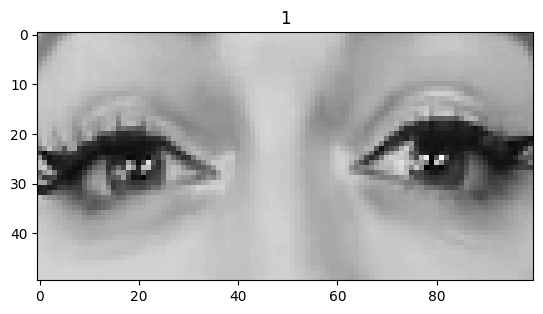

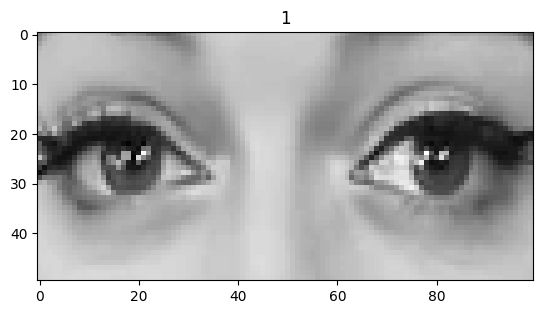

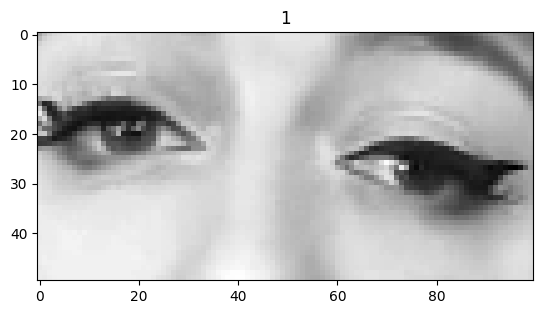

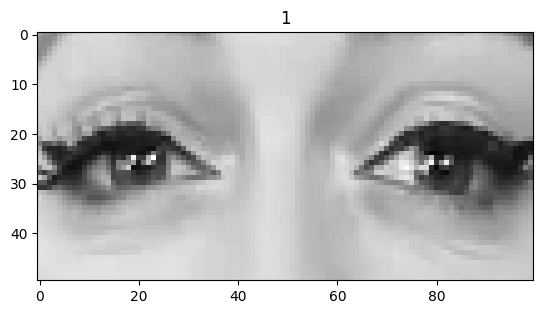

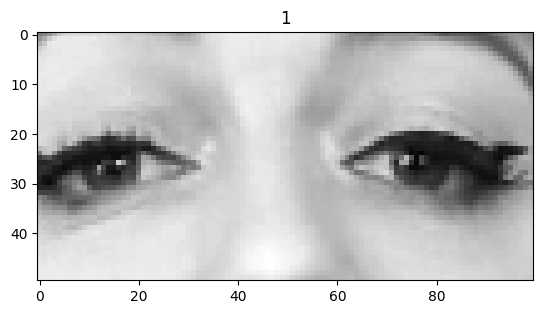

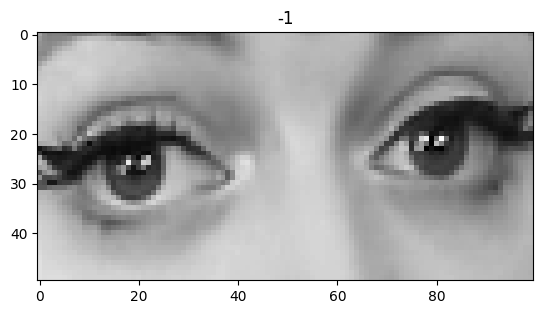

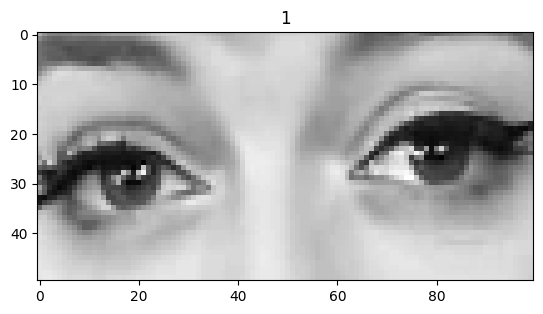

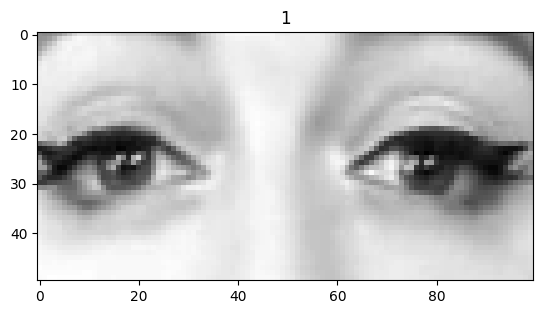

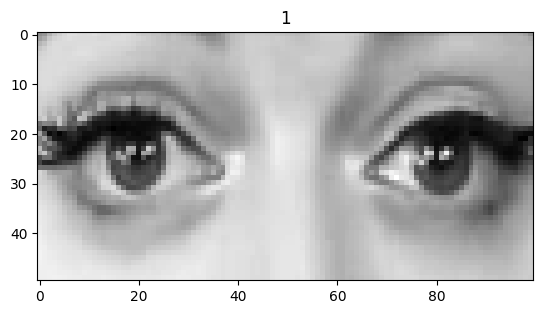

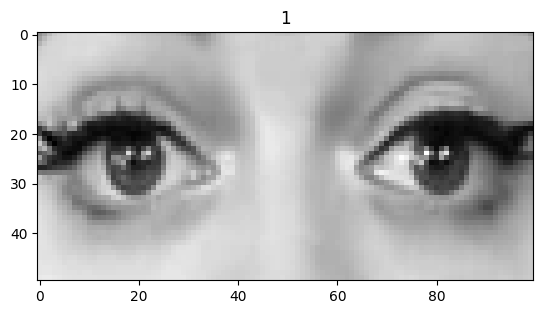

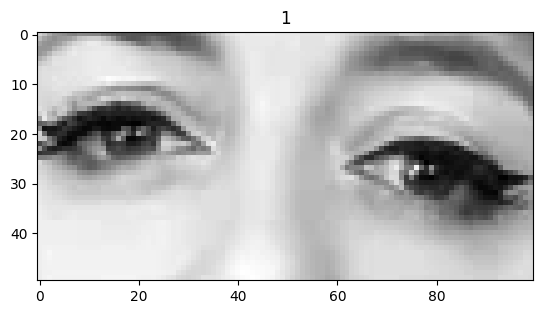

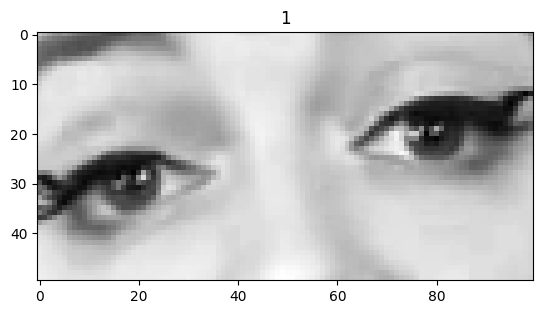

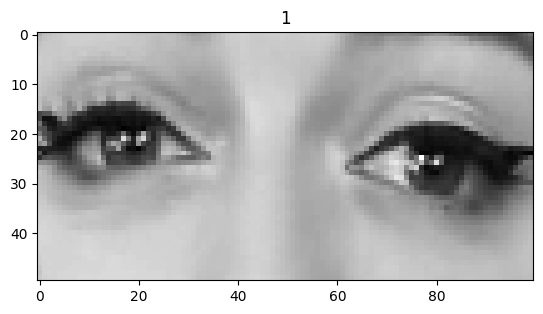

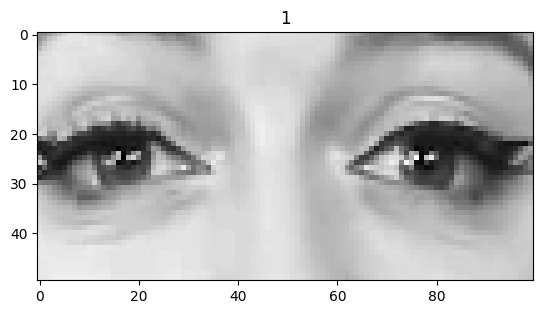

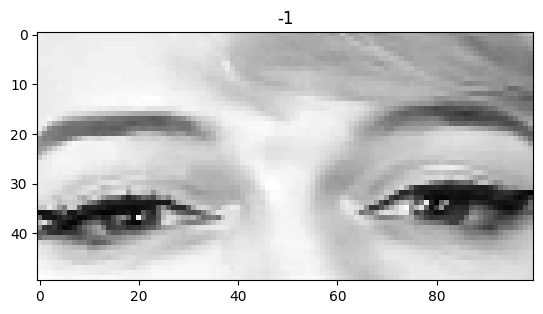

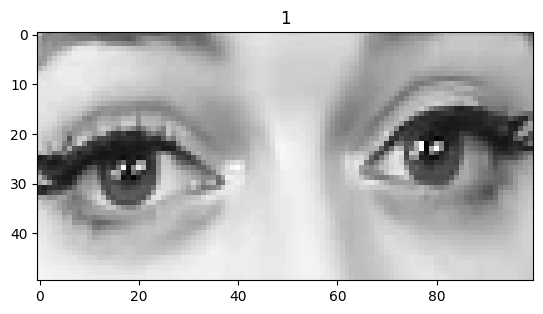

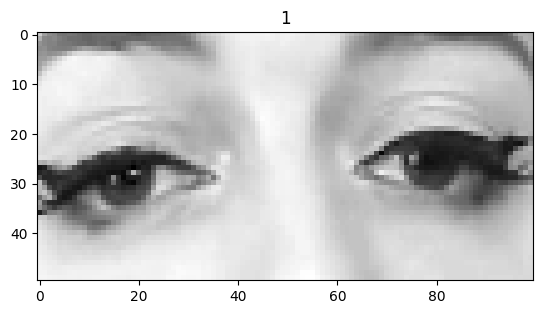

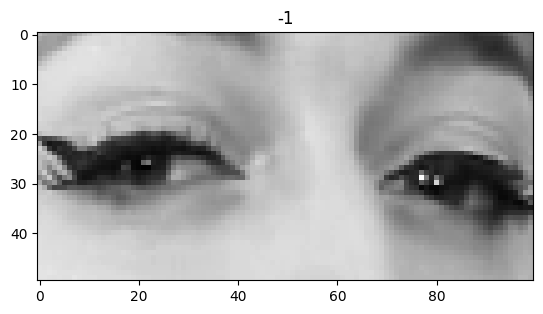

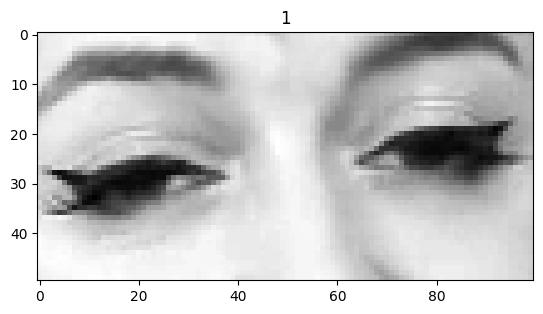

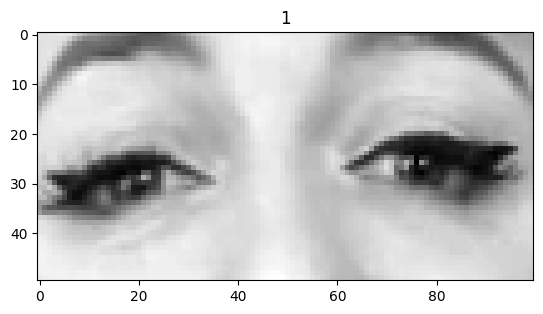

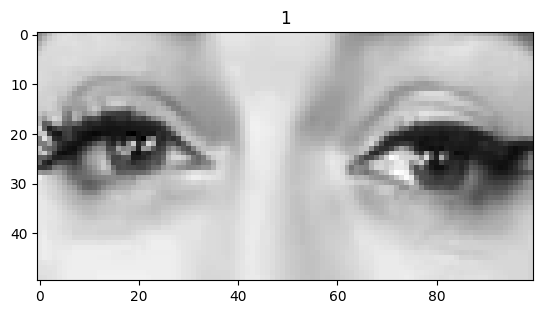

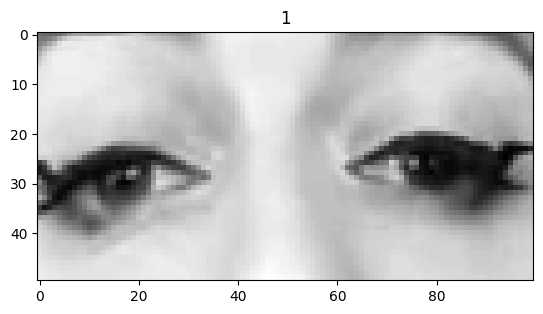

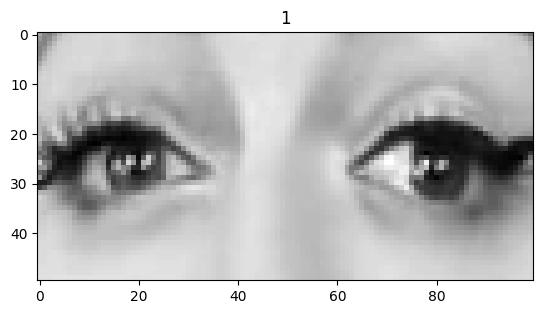

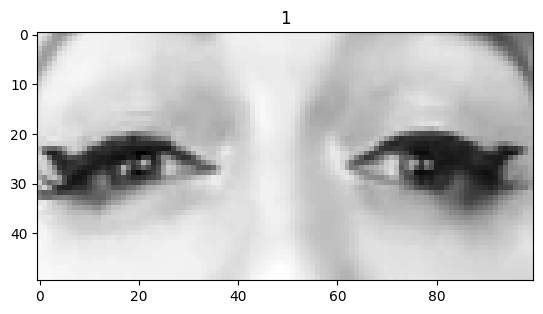

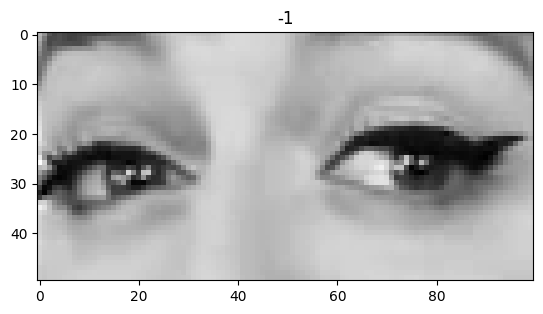

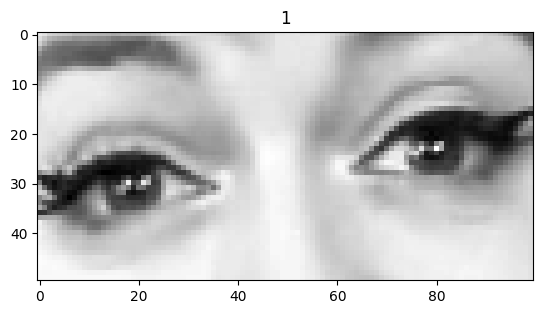

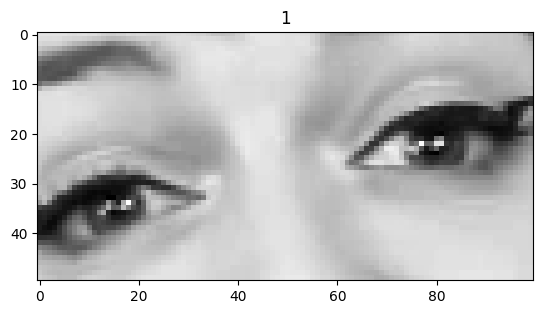

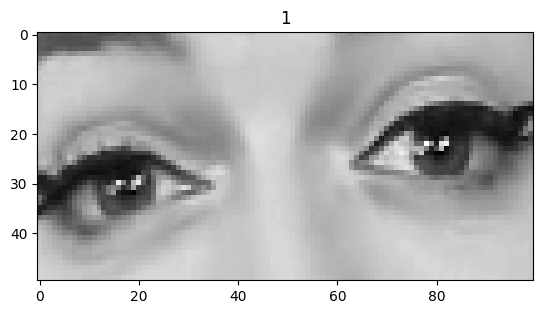

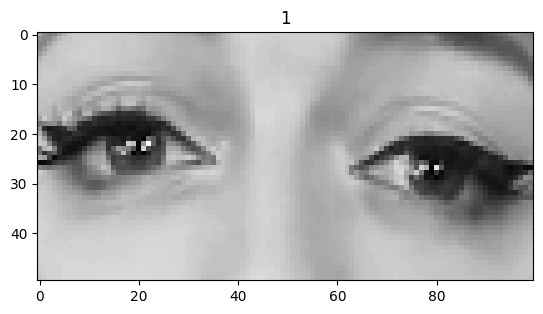

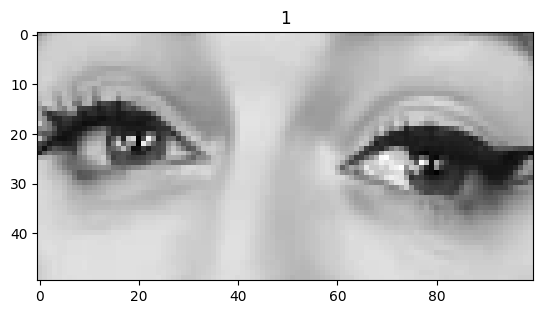

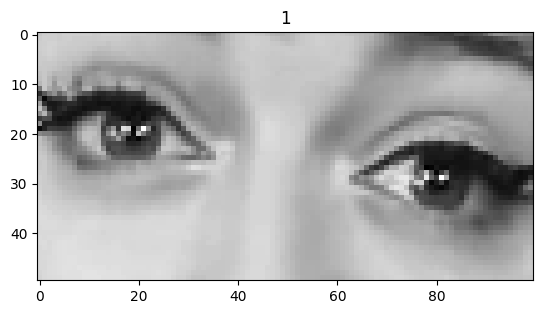

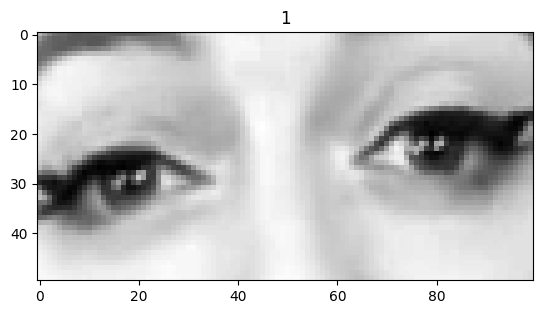

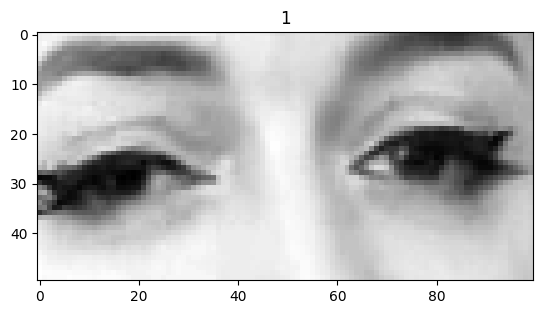

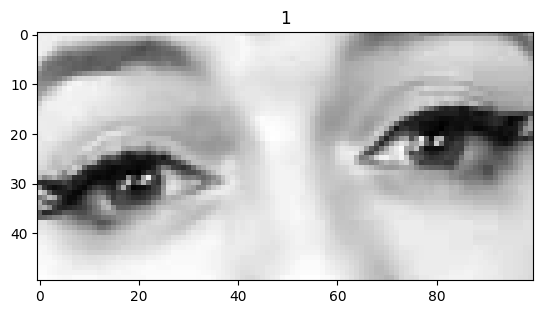

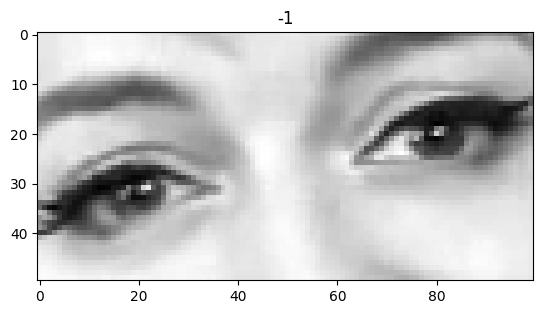

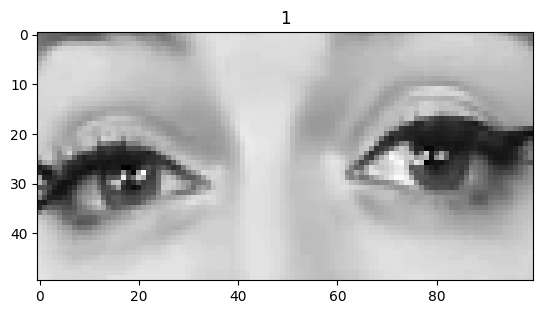

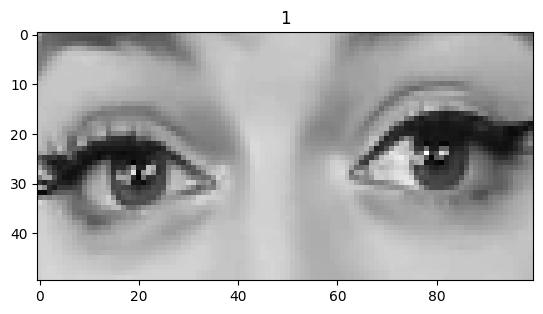

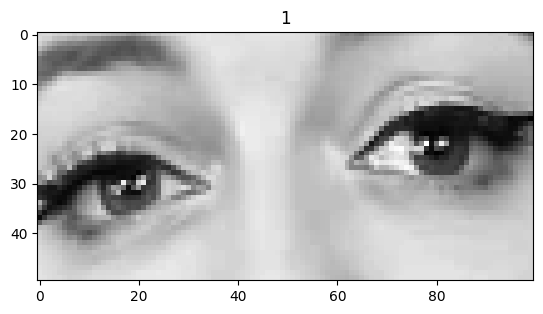

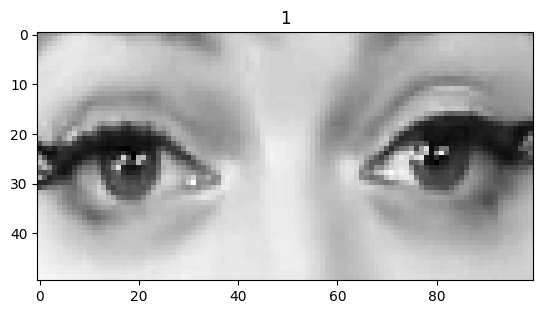

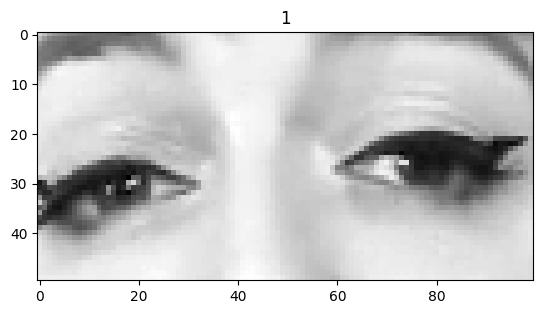

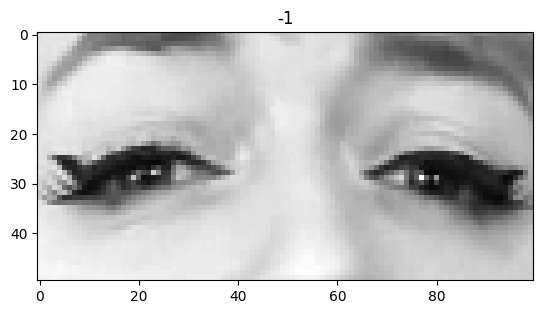

In [35]:
# fig = plt.subplots(NROWS, NCOLS)
for idx, i in enumerate(predicts):
    if idx > 50:
        break
    plt.imshow(both[idx], cmap="gray")
    plt.title(i)
    plt.show()




In [4]:
for i in both_eyes:
    try:
        print(i.shape)
    except:
        pass

(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)


In [5]:
for i in eyes_list:
    try:
        print(i[0].shape, i[1].shape)
    except:
        pass

(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (